In [19]:
import itertools
import random
import time
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Algoritmi

def calculate_completion_time(schedule, execution_times, m):
    processor_times = [0] * m
    for task, processor in enumerate(schedule):
        processor_times[processor] += execution_times[task][processor]
    return max(processor_times)

def brute_force(execution_times, m, max_time=5):
    T = len(execution_times)
    start = time.time()
    if m ** T > 100000:  # preskakanje prevelikih problema
        return None, "Over time limit"
    best_schedule = None
    best_makespan = float('inf')
    for schedule in itertools.product(range(m), repeat=T):
        current_makespan = calculate_completion_time(schedule, execution_times, m)
        if current_makespan < best_makespan:
            best_schedule = schedule
            best_makespan = current_makespan
        if time.time() - start > max_time:
            return None, "Over limit"
    return best_schedule, best_makespan

def local_search(execution_times, m, max_iterations):
    T = len(execution_times)
    schedule = [random.randint(0, m - 1) for _ in range(T)]
    current_makespan = calculate_completion_time(schedule, execution_times, m)
    best_schedule = schedule[:]
    best_makespan = current_makespan
    for _ in range(max_iterations):
        new_schedule = schedule[:]
        task = random.randint(0, T - 1)
        new_schedule[task] = random.randint(0, m - 1)
        new_makespan = calculate_completion_time(new_schedule, execution_times, m)
        if new_makespan < current_makespan:
            schedule = new_schedule
            current_makespan = new_makespan
        if new_makespan < best_makespan:
            best_schedule = new_schedule[:]
            best_makespan = new_makespan
    return best_schedule, best_makespan

def simulated_annealing(execution_times, m, max_iterations):
    T = len(execution_times)
    schedule = [random.randint(0, m - 1) for _ in range(T)]
    current_makespan = calculate_completion_time(schedule, execution_times, m)
    best_schedule = schedule[:]
    best_makespan = current_makespan
    for i in range(1, max_iterations):
        new_schedule = schedule[:]
        task = random.randint(0, T - 1)
        new_schedule[task] = random.randint(0, m - 1)
        new_makespan = calculate_completion_time(new_schedule, execution_times, m)
        if new_makespan < current_makespan or random.uniform(0,1) < 1.0/i**0.5:
            schedule = new_schedule
            current_makespan = new_makespan
            if new_makespan < best_makespan:
                best_schedule = new_schedule[:]
                best_makespan = new_makespan
    return best_schedule, best_makespan

# GA
class Individual:
    def __init__(self, T, m, execution_times):
        self.code = [random.randint(0, m-1) for _ in range(T)]
        self.execution_times = execution_times
        self.m = m
        self.calc_fitness()
    def calc_fitness(self):
        processor_times = [0]*self.m
        for task, processor in enumerate(self.code):
            processor_times[processor] += self.execution_times[task][processor]
        self.fitness = -max(processor_times)

def selection(population, k):
    participants = random.sample(population, min(k,len(population)))
    return max(participants,key=lambda x: x.fitness)

def crossover(p1,p2,c1,c2):
    point = random.randint(1,len(p1.code)-1)
    c1.code[:point],c1.code[point:] = p1.code[:point],p2.code[point:]
    c2.code[:point],c2.code[point:] = p2.code[:point],p1.code[point:]

def mutation(ind,p):
    for i in range(len(ind.code)):
        if random.random() < p:
            ind.code[i] = random.randint(0,ind.m-1)

def genetic_algorithm(T,m,execution_times,pop_size,num_gen,tourn_size,mut_prob,elitism):
    population = [Individual(T,m,execution_times) for _ in range(pop_size)]
    new_population = [Individual(T,m,execution_times) for _ in range(pop_size)]
    if elitism % 2 != pop_size %2:
        elitism+=1
    for _ in range(num_gen):
        population.sort(key=lambda x: x.fitness,reverse=True)
        new_population[:elitism] = deepcopy(population[:elitism])
        for i in range(elitism,pop_size,2):
            p1 = selection(population,tourn_size)
            p2 = selection(population,tourn_size)
            crossover(p1,p2,new_population[i],new_population[i+1])
            mutation(new_population[i],mut_prob)
            mutation(new_population[i+1],mut_prob)
            new_population[i].calc_fitness()
            new_population[i+1].calc_fitness()
        population = deepcopy(new_population)
    best = max(population,key=lambda x:x.fitness)
    return best.code, -best.fitness

# PSO
class Particle:
    swarm_best_position = None
    swarm_best_value = float('inf')
    def __init__(self,T,m,execution_times,c_inertia,c_social,c_cognitive):
        self.T,self.m = T,m
        self.execution_times = execution_times
        self.c_inertia,self.c_social,self.c_cognitive = c_inertia,c_social,c_cognitive
        self.position = np.random.randint(0,m,size=T)
        self.velocity = np.random.uniform(-1,1,size=T)
        self.value = self.calculate_completion_time()
        self.personal_best_position = self.position.copy()
        self.personal_best_value = self.value
        if Particle.swarm_best_position is None or self.value<Particle.swarm_best_value:
            Particle.swarm_best_position = self.position.copy()
            Particle.swarm_best_value = self.value
    def calculate_completion_time(self):
        times = [0]*self.m
        for task,proc in enumerate(self.position):
            times[proc]+=self.execution_times[task][proc]
        return max(times)
    def update_velocity(self):
        r_s = np.random.random(len(self.position))
        r_c = np.random.random(len(self.position))
        social_velocity = self.c_social*r_s*(Particle.swarm_best_position-self.position)
        cognitive_velocity = self.c_cognitive*r_c*(self.personal_best_position-self.position)
        self.velocity = self.c_inertia*self.velocity+social_velocity+cognitive_velocity
    def move(self):
        self.update_velocity()
        self.position = np.clip(self.position+self.velocity,0,self.m-1).astype(int)
        self.value = self.calculate_completion_time()
        if self.value<self.personal_best_value:
            self.personal_best_value=self.value
            self.personal_best_position=self.position.copy()
            if self.value<Particle.swarm_best_value:
                Particle.swarm_best_value=self.value
                Particle.swarm_best_position=self.position.copy()

def pso(T,m,execution_times,num_iters,swarm_size,c_inertia,c_social,c_cognitive):
    Particle.swarm_best_position=None
    Particle.swarm_best_value=float('inf')
    swarm=[Particle(T,m,execution_times,c_inertia,c_social,c_cognitive) for _ in range(swarm_size)]
    for _ in range(num_iters):
        for p in swarm:
            p.move()
    return Particle.swarm_best_position, Particle.swarm_best_value

In [ ]:
def generate_tasks(T,m,max_time=10):
    return [[random.randint(1,max_time) for _ in range(m)] for _ in range(T)]

In [15]:
def run_experiment(T, m, execution_times, max_iterations, population_size, num_generations, tournament_size, mutation_prob, elitism_size):
    results = {}
    
    # Brute Force
    start=time.time()
    schedule, makespan = brute_force(execution_times, m)
    end=time.time()
    if schedule is None:
        results["Brute Force"] = "Skipped"
    else:
        results["Brute Force"] = {"Schedule":schedule,"Makespan":makespan,"Time":end-start}
    
    # Local Search
    start=time.time()
    schedule,makespan=local_search(execution_times,m,max_iterations)
    end=time.time()
    results["Local Search"] = {"Schedule":schedule,"Makespan":makespan,"Time":end-start}
    
    # Simulated Annealing
    start=time.time()
    schedule,makespan=simulated_annealing(execution_times,m,max_iterations)
    end=time.time()
    results["Simulated Annealing"] = {"Schedule":schedule,"Makespan":makespan,"Time":end-start}
    
    # Genetic Algorithm
    start=time.time()
    schedule,makespan=genetic_algorithm(T,m,execution_times,population_size,num_generations,tournament_size,mutation_prob,elitism_size)
    end=time.time()
    results["Genetic Algorithm"] = {"Schedule":schedule,"Makespan":makespan,"Time":end-start}
    
    # PSO
    start=time.time()
    schedule,makespan=pso(T,m,execution_times,max_iterations,swarm_size=20,c_inertia=0.7,c_social=1.5,c_cognitive=1.5)
    end=time.time()
    results["PSO"] = {"Schedule":schedule,"Makespan":makespan,"Time":end-start}
    
    return results

In [18]:
def plot_heatmap(matrix, xlabels, ylabels, title, cmap="viridis"):
    plt.figure(figsize=(12, 6))
    sns.heatmap(matrix, annot=True, xticklabels=xlabels, yticklabels=ylabels, cmap=cmap, fmt=".1f")
    plt.title(title)
    plt.xlabel("Problem Size")
    plt.ylabel("Algorithm")
    plt.tight_layout()
    plt.show()


def visualize_schedule(schedule, execution_times, m, title):
    heat = [[0] * len(schedule) for _ in range(m)]
    for t, p in enumerate(schedule):
        heat[p][t] = execution_times[t][p]
    plt.figure(figsize=(10, 4))
    sns.heatmap(heat, annot=True, fmt="d", cmap="YlOrRd")
    plt.title(title)
    plt.xlabel("Task")
    plt.ylabel("Processor")
    plt.show()

In [16]:
def visualize_results(results_all, problem_sizes, execution_times_all):
    algorithms = list(results_all[0].keys())
    colors = sns.color_palette("Set2", len(algorithms))

    # Heatmap(za jedan problem)
    last_idx = -3
    last_res = results_all[last_idx]
    last_T, last_m = problem_sizes[last_idx]
    execution_times = execution_times_all[last_idx]

    algorithms_heat = ["Local Search", "Simulated Annealing", "Genetic Algorithm", "PSO"]
    for algo in algorithms_heat:
        res = last_res.get(algo)
        if isinstance(res, dict):
            visualize_schedule(res["Schedule"], execution_times, last_m,
                               f"{algo} Schedule Heatmap (T={last_T}, m={last_m})")

    # Makespan(bar)
    makespans, labels = [], []
    for algo, res in last_res.items():
        if isinstance(res, dict):
            makespans.append(res["Makespan"])
            labels.append(algo)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=labels, y=makespans, palette="Set2", hue=labels,  legend=False)
    plt.ylabel("Makespan (lower is better)")
    plt.title(f"Makespan Comparison (T={last_T}, m={last_m})")
    plt.show()

    # Time(bar)
    times, labels = [], []
    for algo, res in last_res.items():
        if isinstance(res, dict):
            times.append(res["Time"])
            labels.append(algo)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=labels, y=times, palette="Set2", hue=labels,  legend=False)
    plt.ylabel("Execution Time (s)")
    plt.title(f"Execution Time Comparison (T={last_T}, m={last_m})")
    plt.show()

    # Plot(Makespan, Problem Size)
    plt.figure(figsize=(12, 6))
    for i, algo in enumerate(algorithms):
        makespans = []
        for res in results_all:
            if isinstance(res[algo], dict):
                makespans.append(res[algo]["Makespan"])
            else:
                makespans.append(None)
        plt.plot([f"T={T},m={m}" for T, m in problem_sizes], makespans,
                 marker='o', label=algo, color=colors[i])
    plt.xticks(rotation=45)
    plt.ylabel("Makespan")
    plt.title("Makespan vs Problem Size")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot(Time, Problem Size)
    plt.figure(figsize=(12, 6))
    
    for i, algo in enumerate(algorithms):
        times = []
        for res in results_all:
            if isinstance(res[algo], dict):
                times.append(res[algo]["Time"])
            else:
                times.append(np.nan)  # umesto None -> da se ne prekida ružno
        plt.plot(
            [f"T={T},m={m}" for T, m in problem_sizes],
            times,
            marker='o',
            markersize=7,
            linewidth=2,
            label=algo,
            color=colors[i]
        )
    
    plt.xticks(rotation=45)
    plt.ylabel("Execution Time (s, log scale)")
    plt.title("Execution Time vs Problem Size")
    plt.yscale("log")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


    # Scatter plot (Makespan vs Time)
    plt.figure(figsize=(8,6))
    for i, (algo, res) in enumerate(last_res.items()):
        if isinstance(res, dict):
            plt.scatter(res["Time"], res["Makespan"], s=100, color=colors[i], label=algo, alpha=0.8, edgecolors="k")
    plt.xlabel("Execution Time (s)")
    plt.ylabel("Makespan")
    plt.title(f"Makespan vs Execution Time (T={last_T}, m={last_m})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Relative Makespan
    plt.figure(figsize=(12,6))
    for i, algo in enumerate(algorithms):
        rel_makespans = []
        for res in results_all:
            vals = [r["Makespan"] for r in res.values() if isinstance(r, dict)]
            best = min(vals) if vals else None
            if isinstance(res[algo], dict) and best:
                rel_makespans.append(res[algo]["Makespan"]/best)
            else:
                rel_makespans.append(None)
        plt.plot([f"T={T},m={m}" for T,m in problem_sizes], rel_makespans,
                 marker='o', label=algo, color=colors[i])
    plt.xticks(rotation=45)
    plt.ylabel("Relative Makespan (× best)")
    plt.title("Relative Makespan vs Problem Size")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # global heatmap
    problem_labels = [f"T={T},m={m}" for (T, m) in problem_sizes]

    makespan_matrix = []
    for algo in algorithms:
        row_m = []
        for res in results_all:
            if isinstance(res[algo], dict):
                row_m.append(res[algo]["Makespan"])
            else:
                row_m.append(np.nan)
        makespan_matrix.append(row_m)

    plot_heatmap(makespan_matrix, problem_labels, algorithms, "Global Makespan Heatmap")


Problem size: T=6, m=2
Brute Force: Makespan=11, Time=0.00s
Local Search: Makespan=18, Time=0.00s
Simulated Annealing: Makespan=11, Time=0.00s
Genetic Algorithm: Makespan=11, Time=0.03s
PSO: Makespan=11, Time=0.07s

Problem size: T=8, m=2
Brute Force: Makespan=14, Time=0.00s
Local Search: Makespan=16, Time=0.00s
Simulated Annealing: Makespan=17, Time=0.00s
Genetic Algorithm: Makespan=14, Time=0.02s
PSO: Makespan=17, Time=0.05s

Problem size: T=10, m=2
Brute Force: Makespan=17, Time=0.00s
Local Search: Makespan=24, Time=0.00s
Simulated Annealing: Makespan=20, Time=0.00s
Genetic Algorithm: Makespan=17, Time=0.02s
PSO: Makespan=19, Time=0.09s

Problem size: T=10, m=3
Brute Force: Makespan=11, Time=0.06s
Local Search: Makespan=20, Time=0.00s
Simulated Annealing: Makespan=17, Time=0.00s
Genetic Algorithm: Makespan=11, Time=0.02s
PSO: Makespan=17, Time=0.06s

Problem size: T=12, m=3
Brute Force: Skipped
Local Search: Makespan=17, Time=0.00s
Simulated Annealing: Makespan=16, Time=0.00s
Genet

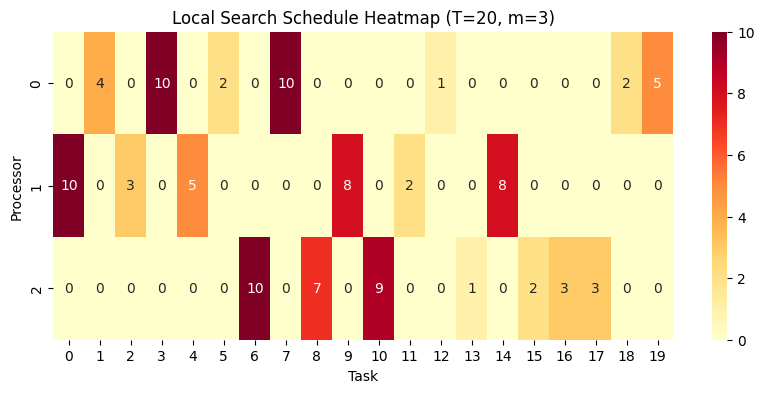

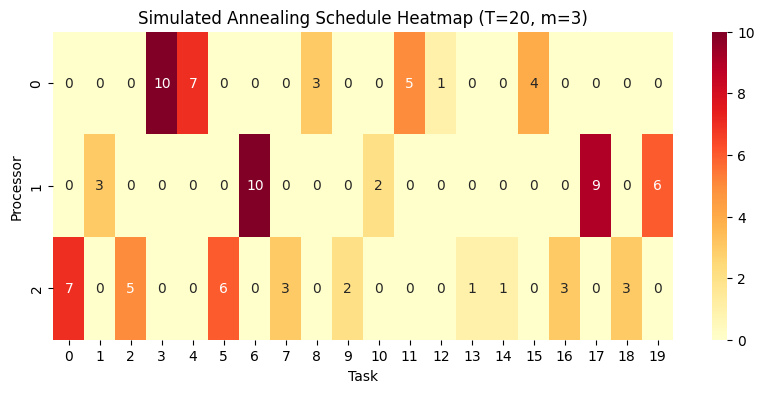

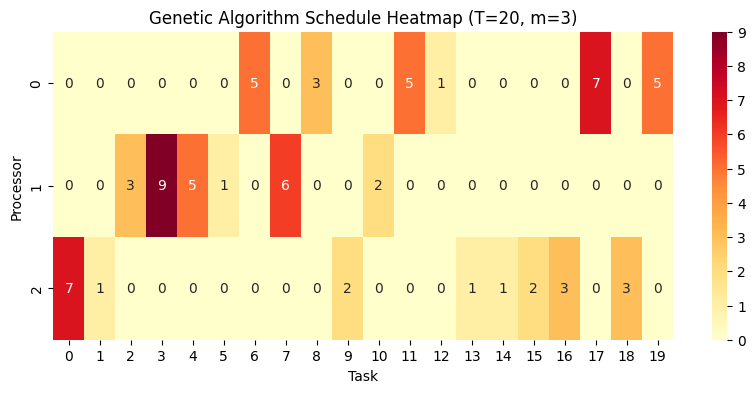

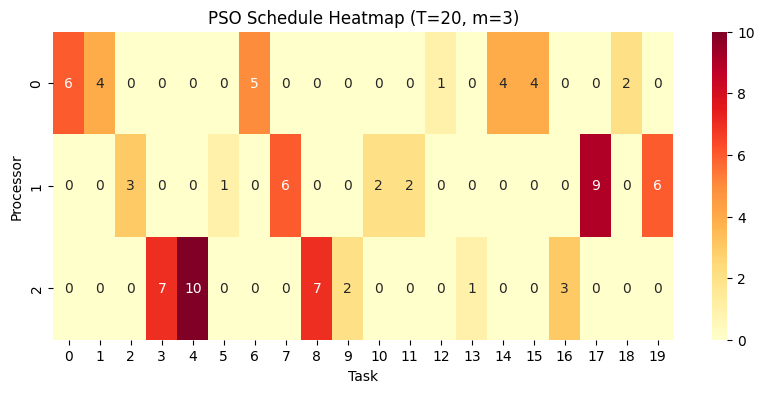

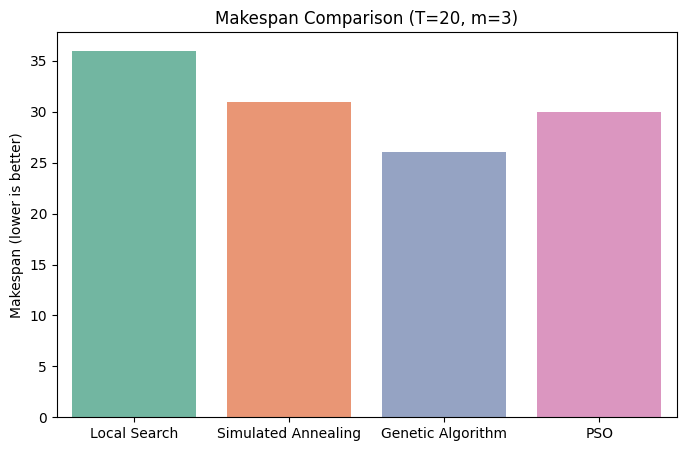

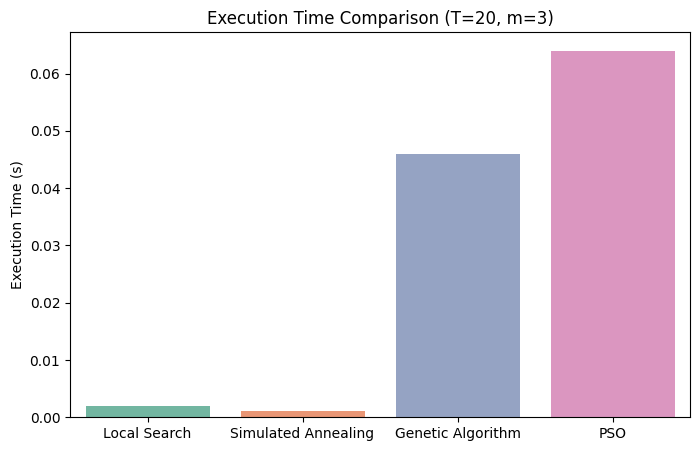

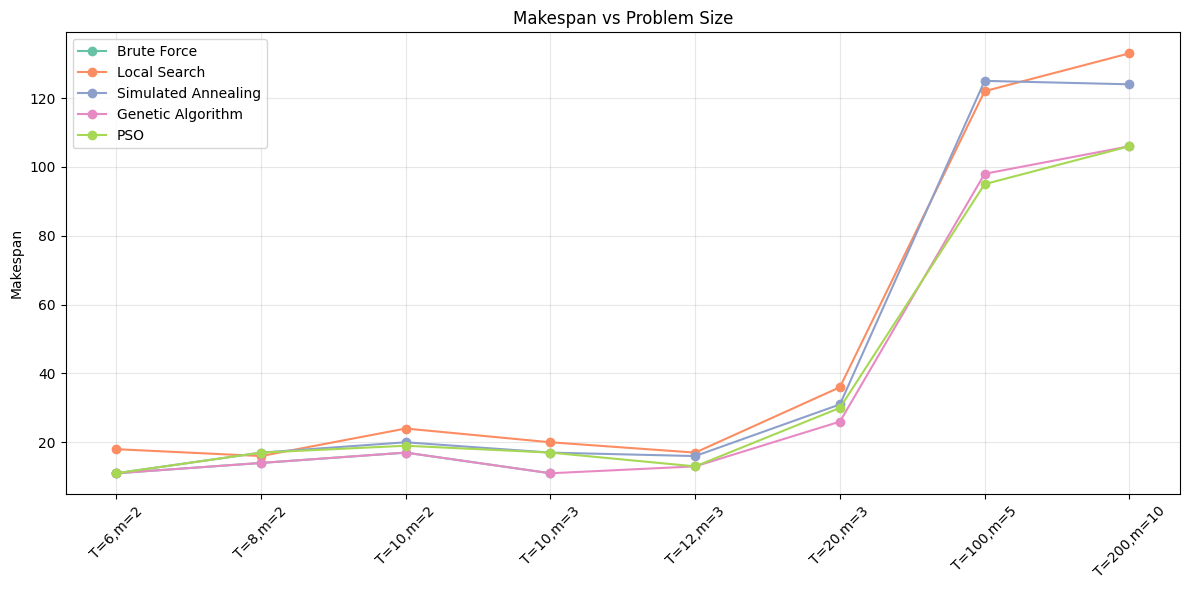

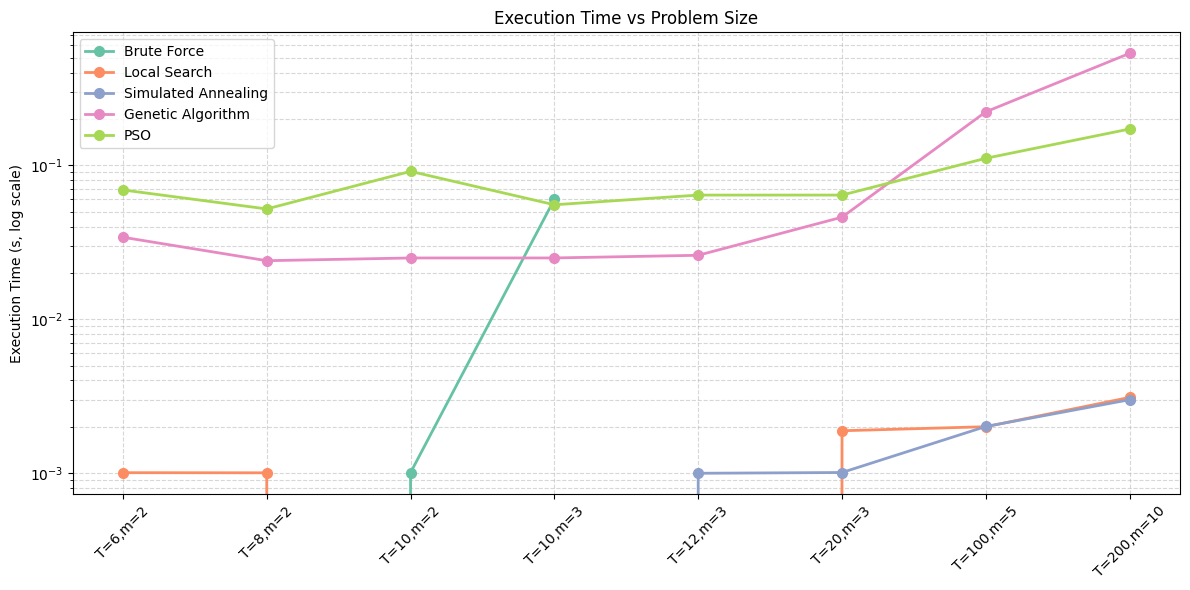

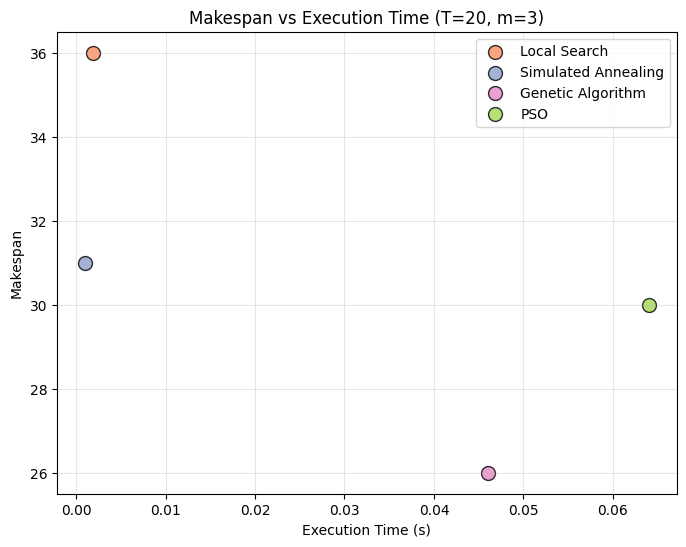

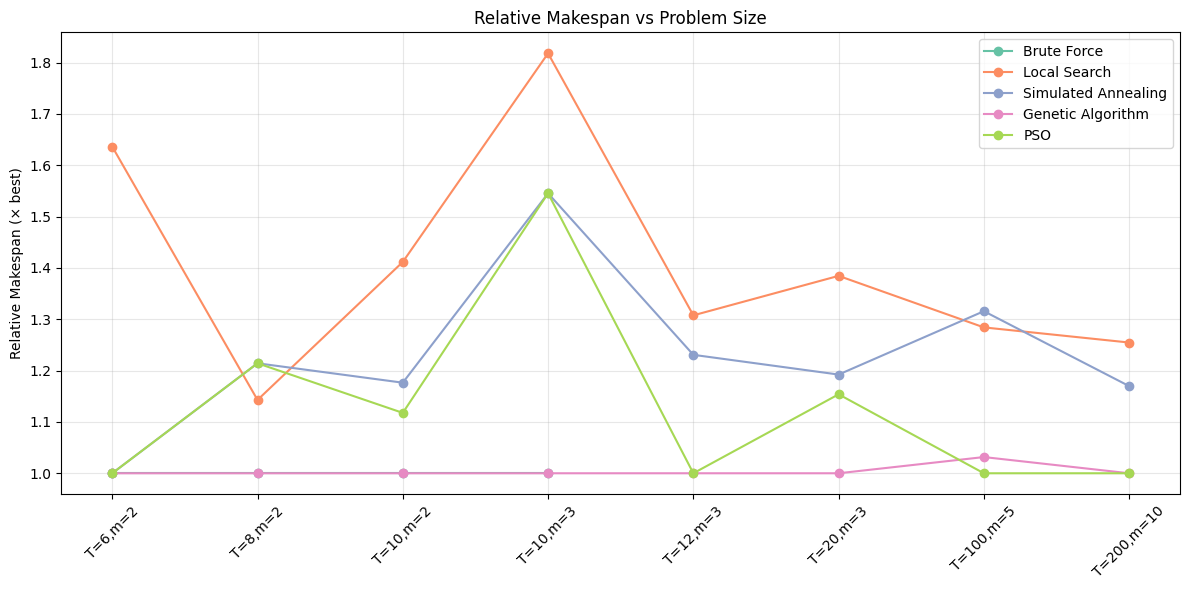

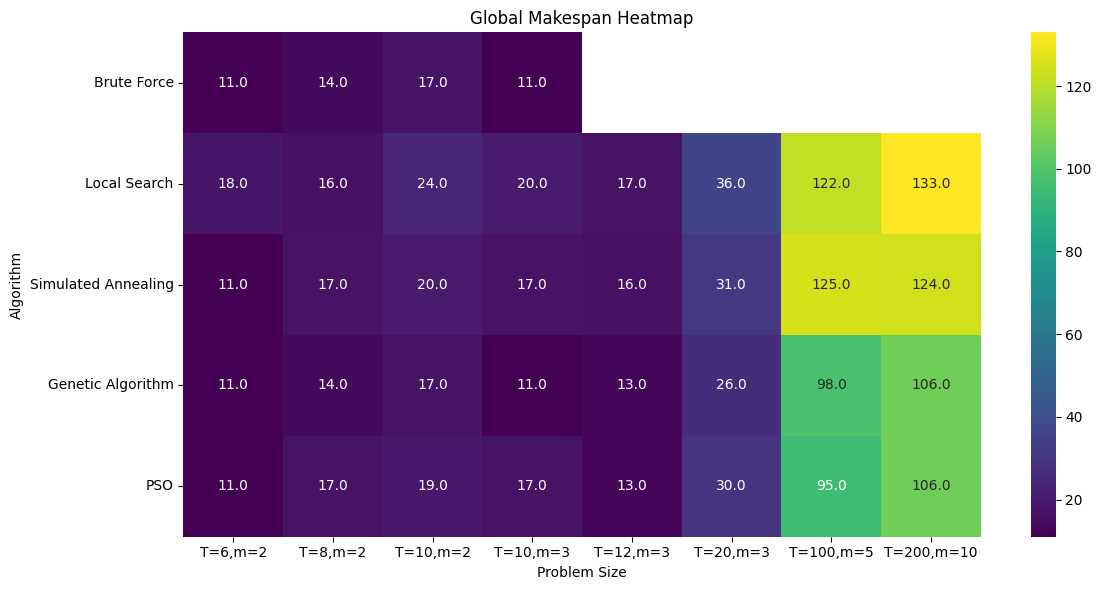

In [17]:
# Izvrsavanje

problem_sizes=[(6,2),(8,2),(10,2),(10,3),(12,3),(20,3),(100,5),(200,10)] # manji za demo
max_iterations = 200
population_size = 30
num_generations = 50
tournament_size = 3
mutation_prob = 0.2
elitism_size = 4

results_all = []
execution_times_all = []

for T, m in problem_sizes:
    execution_times = generate_tasks(T, m)
    execution_times_all.append(execution_times)

    print(f"\nProblem size: T={T}, m={m}")
    results = run_experiment(T, m, execution_times, max_iterations,
                             population_size, num_generations,
                             tournament_size, mutation_prob, elitism_size)
    results_all.append(results)

    for algo, res in results.items():
        if isinstance(res, dict):
            print(f"{algo}: Makespan={res['Makespan']}, Time={res['Time']:.2f}s")
        else:
            print(f"{algo}: {res}")

visualize_results(results_all, problem_sizes, execution_times_all)